In [1]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch import optim
import torchvision.transforms as T
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

In [15]:
def main():
    seed = 1000
    th.manual_seed(seed)
    if th.cuda.is_available():
    # Make CuDNN Determinist
        th.backends.cudnn.deterministic = True
        th.cuda.manual_seed(seed)
    #Directories
    trainDirectory = "./Data/archive/Data/train"
    testDirectory = "./Data/archive/Data/test"

    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    #checking for model
    net = input("Press 1 if you want to use Model 1\nPress any other key if you want to use Model 2 : ")

    if net == "1":
        #checking for greyScale and Loading the images
        greyScale = input("Enter 1 if you want to use convert channel of image to 1 otherwise press any other key : ")
        if greyScale == "1":
            greyScale = True
        else:
            greyScale = False
    
        trainLoader, valLoader, testLoader = imageDataLoader(trainDirectory, testDirectory, greyScale)

        #Initialising a network
        net = ConvolutionalNetwork_1(greyScale)
        #Training the model
        trainHistory, valHistory = train(net, batchSize=100, nEpochs=10, learningRate=0.001, device=device, trainSet=trainLoader, valSet=valLoader)

        #plotting the curves
        plotLosses(trainHistory, valHistory, "Net 1")
#         net.load_state_dict(th.load(bestModelPath))

        #computing the accuracies
        print("\nEvaluation of the model...")
        testing(net, trainLoader, valLoader, testLoader,  device = device)


    else:
        #checking for greyScale and Loading the images
        greyScale = input("Enter 1 if you want to use greyScale image otherwise press any other key : ")
        if greyScale == "1":
            greyScale = True
        else:
            greyScale = False
        trainLoader, valLoader, testLoader = imageDataLoader(trainDirectory, testDirectory, greyScale, model2 = True)

        #Initialising a network
        net = ConvolutionalNetwork_2(greyScale)

        #Training the model
        trainHistory, valHistory = train(net, batchSize=100, nEpochs=10, learningRate=0.001,  device=device, trainSet=trainLoader, valSet=valLoader)

        #plotting the curves
        plotLosses(trainHistory, valHistory, "Net 2")
#         net.load_state_dict(th.load(bestModelPath))

        #computing the accuracies
        print("\nEvaluation of the model...")
        testing(net, trainLoader, valLoader, testLoader,  device = device)


In [3]:
def imageDataLoader(trainDirectory, testDirectory, greyScale = False, model2 = False):
    """
    This method takes the directory of test and train data, split the train data in training and validation data,
    make the apprpriate transformations and return the training, testing and valdation data
    """
    #Making Transforms
    if model2:
        if greyScale:
            transform = T.Compose([
                T.Grayscale(num_output_channels=1), T.Resize((32,32)),
                T.ToTensor(), T.RandomHorizontalFlip()])
        else:
            transform = T.Compose([
                T.ToTensor(),  T.Resize((32,32)), T.RandomHorizontalFlip()])
    else:
        if greyScale:
            transform = T.Compose([
                T.Grayscale(num_output_channels=1),  T.Resize((32,32)),
                T.ToTensor()])
        else:
            transform = T.Compose([
                T.ToTensor(), T.Resize((32,32))])

    #Loading the images from firectory
    dataset =   ImageFolder(trainDirectory, transform=transform)
    testData = ImageFolder(testDirectory, transform=transform)
    batchSize = 100
    #Defining the spliting
    valSize = int(len(dataset) * 0.2)
    trainSize =  len(dataset) - valSize
    valSize = int(len(dataset) * 0.2)
    trainData, valData = random_split(dataset, [trainSize, valSize])

    #Loading the data in batches
    trainLoader = DataLoader(trainData, batchSize, shuffle=True)
    testLoader = DataLoader(testData, batchSize, shuffle=True)
    valLoader = DataLoader(valData, batchSize, shuffle=True)


    return trainLoader, valLoader, testLoader

In [4]:
class ConvolutionalNetwork_1(nn.Module):
    """
    A simple neural network with one convolutional layer, one pooling layer and two fully connected layers
    
    """
    def __init__(self, greyScale):
        super(ConvolutionalNetwork_1, self).__init__()
        #deciding the input channels
        if greyScale:
            inChannels = 1
        else:
            inChannels = 3

        #defining hyperparameters
        kernelSize = 3
        stride =  1
        self.outChannels = 32
        zeroPadding = 1
        inSize = 32
        kernelSizePool = 2
        stridePool =  2
        zeroPaddingPool = 0

        #Initialising the layers
        self.conv1 = nn.Conv2d(inChannels, self.outChannels, kernel_size=kernelSize, stride=stride, padding=zeroPadding)
        #Computing the out height
        h2 = outSize(inSize = inSize, kernelSize = kernelSize, stride=stride, padding=zeroPadding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        #Computing the out height
        self.h3 = outSize(inSize = h2, kernelSize = kernelSizePool, stride=stridePool, padding=zeroPaddingPool)
        self.fc1 = nn.Linear(int(self.outChannels * self.h3 * self.h3), 64) 
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        """
        Forward pass of the network
        """
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        #Flattening the convolution
        x = x.view(-1, int(self.outChannels * self.h3 * self.h3))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
class ConvolutionalNetwork_2(nn.Module):
    """
    A modified neural network with two convolutional layer, two batchnorm layers, one pooling layer and three fully connected layers
    
    """
    def __init__(self, greyScale):
        super(ConvolutionalNetwork_2, self).__init__()
        #deciding the input channels
        if greyScale:
            inChannels = 1
        else:
            inChannels = 3

        #defining hyperparameters
        kernelSize = 3
        stride =  1
        self.outChannels = 64
        zeroPadding = 1
        inSize = 32
        kernelSizePool = 2
        stridePool =  2
        zeroPaddingPool = 0

        #Initialising the layers
        self.conv1 = nn.Conv2d(inChannels, 32, kernel_size=kernelSize, stride=stride, padding=zeroPadding)
        #Computing the out height
        h2 = outSize(inSize = inSize, kernelSize = 3, stride=1, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernelSize, stride=stride, padding=zeroPadding)
        #Computing the out height
        h3 = outSize(inSize = h2, kernelSize = 3, stride=1, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        #Computing the out height
        self.h4 = outSize(inSize = h3, kernelSize = kernelSizePool, stride=stridePool, padding=zeroPaddingPool)
        self.fc1 = nn.Linear(int(self.outChannels * self.h4 * self.h4), 32)  
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        """
        Forward pass of the network
        """
        x = F.relu(self.batchNorm1(self.conv1(x)))
        x = F.relu(self.batchNorm2(self.conv2(x)))
        x = self.pool(x)
        #Flattening the convolution
        x = x.view(-1, int(self.outChannels * self.h4 * self.h4))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
def outSize(inSize, kernelSize, stride=1, padding=0):
    """This method Calculats the out size of layer by using the formula (N -F+2P)/S+1"""
    return int((inSize - kernelSize + 2 * padding) / stride) + 1

In [7]:
def createLossAndOptimizer(net, learningRate=0.001):
    """
    This method defined the loss criteria and the optimiser
    """
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(net.parameters(), lr=learningRate)
    return criterion, optimizer

In [8]:
def train(net, batchSize, nEpochs, learningRate, trainSet, valSet, device):
    """
    Train a neural network and prints out its evolution during the training

    Parameters:    
        net: Convolutional neural network
        batchSize: size of  the batch
        nEpochs: (int)  Number of iterations on the training set
        learningRate: (float) learning rate used by the optimizer
    """
    print("\n===== HYPERPARAMETERS =====")
    print("Batch Size = ", batchSize)
    print("number of Epochs = ", nEpochs)
    print("Learning Rate = ", learningRate)
    print("=" * 27)

    #defining the loss criteria and optimiser
    criterion, optimizer = createLossAndOptimizer(net, learningRate)
    # initialisation of variables used to track record of loss
    trainHistory = []
    valHistory = []

    #Track of best error to update the model
    bestError = np.inf
    bestModelPath = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(nEpochs):  # loop over the dataset multiple times

        runningLoss = 0.0
        # print_every = nMinibatches // 10
        # start_time = time.time()
        totalTrainLoss = 0
        

        
        for inputs, labels in tqdm(trainSet):
            

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            runningLoss += loss.item()
            totalTrainLoss += loss.item()


        trainHistory.append(totalTrainLoss / len(trainSet))

        totalValLoss = 0


        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in valSet:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              valLoss = criterion(predictions, labels)
              totalValLoss += valLoss.item()
            
        valHistory.append(totalValLoss / len(valSet))

        # Save model that performs best on validation set
        if totalValLoss < bestError:
            bestError = totalValLoss
            th.save(net.state_dict(), bestModelPath)

        print("Epoch = ",epoch + 1, ", Training loss = {:.2f}".format(totalTrainLoss / len(trainSet)), ", Validation loss = {:.2f}".format(totalValLoss / len(valSet)))

    
    # Load best model
    net.load_state_dict(th.load(bestModelPath))
    
    return trainHistory, valHistory

In [13]:
def evaluation(net, dataLoader, device,  plot_number, name=""):
    """
    This method takes the network and data compute the accuracy of model on the data
    """
    print("Evaluation of the network on {} data".format(name))
    correct = 0
    total = 0
    label = []
    predictions = []
    for images, labels in tqdm(dataLoader):

        images, labels = images.to(device), labels.to(device)

        outputs = net(images)
        _, predicted = th.max(outputs, 1)
#         print(list(labels))
#         print(list(predicted))
        predictions += list(predicted)
        label += list(labels)

#         total += labels.size(0)
#         correct += (predicted == labels).sum()
#     accuracy = 100 * float(correct) / total
#     print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

    cm = confusion_matrix(label, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot = True, xticklabels=["Covid", "Normal", "pneumonia"], yticklabels=["Covid", "Normal", "pneumonia"])
    plt.show()
    print("Evaluation Report")
    print(classification_report(label, predictions))

In [10]:
def testing(net, trainLoader, valLoader, testLoader, device):
    """
    This method takes the training, validation and test data, calls the accuracy function to calculate accuracy of each data on the traind model
    """
    evaluation(net, trainLoader, name = "Training",  device = device, plot_number=1)
    evaluation(net, valLoader, name = "Validation",  device = device, plot_number=2)
    evaluation(net, testLoader, name = "Testing",  device = device, plot_number=3)

    

In [11]:
def plotLosses(trainHistory, valHistory, title):
    """
    This method takes in the train history and the validation history on plot it
    """

    x = np.arange(1, len(trainHistory) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(x, trainHistory, label="Training loss", linewidth=2)
    plt.plot(x, valHistory, label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss for " + title)
    plt.show()

# Model 1
### Without Grey Scaling

Press 1 if you want to use Model 1
Press any other key if you want to use Model 2 : 1
Enter 1 if you want to use convert channel of image to 1 otherwise press any other key : n

===== HYPERPARAMETERS =====
Batch Size =  100
number of Epochs =  10
Learning Rate =  0.001


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:49<00:00,  4.03s/it]


Epoch =  1 , Training loss = 0.64 , Validation loss = 0.36


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:42<00:00,  3.86s/it]


Epoch =  2 , Training loss = 0.30 , Validation loss = 0.38


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:40<00:00,  3.82s/it]


Epoch =  3 , Training loss = 0.24 , Validation loss = 0.23


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:38<00:00,  3.77s/it]


Epoch =  4 , Training loss = 0.20 , Validation loss = 0.19


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:42<00:00,  3.86s/it]


Epoch =  5 , Training loss = 0.18 , Validation loss = 0.19


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:45<00:00,  3.95s/it]


Epoch =  6 , Training loss = 0.17 , Validation loss = 0.18


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:42<00:00,  3.87s/it]


Epoch =  7 , Training loss = 0.17 , Validation loss = 0.18


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:19<00:00,  3.33s/it]


Epoch =  8 , Training loss = 0.15 , Validation loss = 0.17


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [03:00<00:00,  4.30s/it]


Epoch =  9 , Training loss = 0.16 , Validation loss = 0.19


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [03:26<00:00,  4.91s/it]


Epoch =  10 , Training loss = 0.13 , Validation loss = 0.18


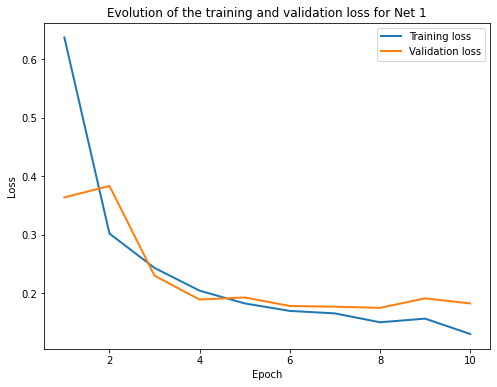


Evaluation of the model...
Evaluation of the network on Training data


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:46<00:00,  3.95s/it]


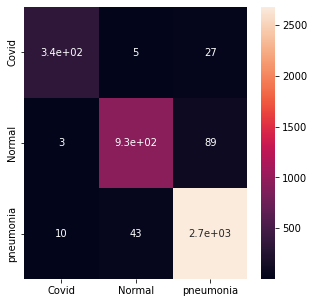

Evaluation Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       367
           1       0.95      0.91      0.93      1021
           2       0.96      0.98      0.97      2728

    accuracy                           0.96      4116
   macro avg       0.96      0.93      0.95      4116
weighted avg       0.96      0.96      0.96      4116

Evaluation of the network on Validation data


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:33<00:00,  3.05s/it]


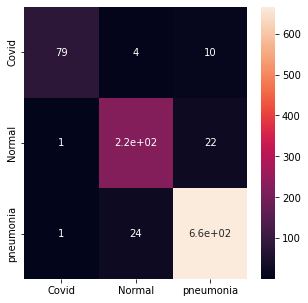

Evaluation Report
              precision    recall  f1-score   support

           0       0.98      0.85      0.91        93
           1       0.89      0.91      0.90       245
           2       0.95      0.96      0.96       690

    accuracy                           0.94      1028
   macro avg       0.94      0.91      0.92      1028
weighted avg       0.94      0.94      0.94      1028

Evaluation of the network on Testing data


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:43<00:00,  3.33s/it]


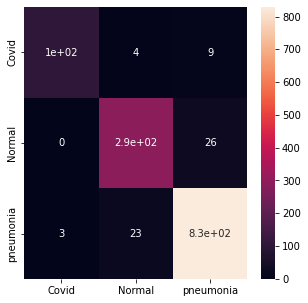

Evaluation Report
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       116
           1       0.92      0.92      0.92       317
           2       0.96      0.97      0.96       855

    accuracy                           0.95      1288
   macro avg       0.95      0.93      0.94      1288
weighted avg       0.95      0.95      0.95      1288



In [16]:
if __name__ == "__main__":
    main()

# Model 2
### Without Grey Scaling

Press 1 if you want to use Model 1
Press any other key if you want to use Model 2 : 2
Enter 1 if you want to use greyScale image otherwise press any other key : d

===== HYPERPARAMETERS =====
Batch Size =  100
number of Epochs =  10
Learning Rate =  0.001


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:24<00:00,  3.45s/it]


Epoch =  1 , Training loss = 0.45 , Validation loss = 0.24


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:26<00:00,  3.48s/it]


Epoch =  2 , Training loss = 0.23 , Validation loss = 0.17


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:23<00:00,  3.41s/it]


Epoch =  3 , Training loss = 0.18 , Validation loss = 0.16


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:22<00:00,  3.40s/it]


Epoch =  4 , Training loss = 0.16 , Validation loss = 0.15


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:22<00:00,  3.39s/it]


Epoch =  5 , Training loss = 0.16 , Validation loss = 0.14


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:21<00:00,  3.37s/it]


Epoch =  6 , Training loss = 0.12 , Validation loss = 0.17


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:21<00:00,  3.38s/it]


Epoch =  7 , Training loss = 0.12 , Validation loss = 0.14


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:21<00:00,  3.38s/it]


Epoch =  8 , Training loss = 0.10 , Validation loss = 0.13


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:22<00:00,  3.39s/it]


Epoch =  9 , Training loss = 0.09 , Validation loss = 0.14


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:22<00:00,  3.40s/it]


Epoch =  10 , Training loss = 0.09 , Validation loss = 0.14


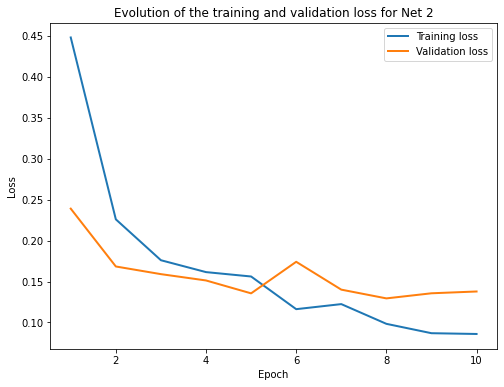


Evaluation of the model...
Evaluation of the network on Training data


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:17<00:00,  3.27s/it]


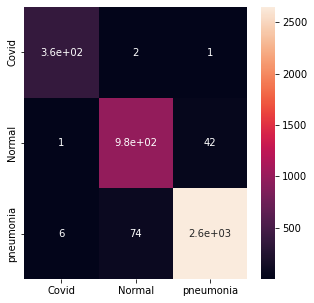

Evaluation Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       367
           1       0.93      0.96      0.94      1021
           2       0.98      0.97      0.98      2728

    accuracy                           0.97      4116
   macro avg       0.96      0.97      0.97      4116
weighted avg       0.97      0.97      0.97      4116

Evaluation of the network on Validation data


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.99s/it]


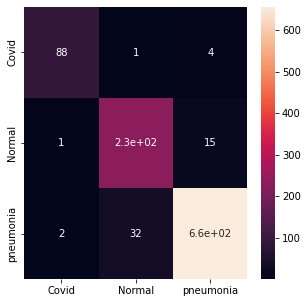

Evaluation Report
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        93
           1       0.87      0.93      0.90       245
           2       0.97      0.95      0.96       690

    accuracy                           0.95      1028
   macro avg       0.94      0.94      0.94      1028
weighted avg       0.95      0.95      0.95      1028

Evaluation of the network on Testing data


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:42<00:00,  3.28s/it]


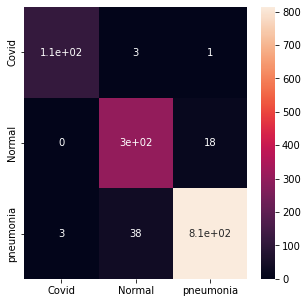

Evaluation Report
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       116
           1       0.88      0.94      0.91       317
           2       0.98      0.95      0.96       855

    accuracy                           0.95      1288
   macro avg       0.94      0.95      0.95      1288
weighted avg       0.95      0.95      0.95      1288



In [17]:
if __name__ == "__main__":
    main()